# Financial Time Series Forecasting: ARIMA, SARIMA, Holt-Winters, Prophet, LSTM

## Fixed Version - Compatible with All Scikit-learn Versions

This notebook uses your local CSV file directly:
- File: `/Users/kushal/Downloads/Major_project-main/Accurcy/expenses_income_summary.csv`
- Compares 5 forecasting algorithms
- Shows accuracy metrics and winner


In [21]:
# Install packages (uncomment if needed)
# !pip install -q numpy pandas matplotlib seaborn scikit-learn statsmodels prophet tensorflow

print("📦 Starting analysis...")

📦 Starting analysis...


In [22]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Classical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prophet
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception as e:
    Prophet = None
    PROPHET_AVAILABLE = False
    print('Prophet not available')

# TensorFlow for LSTM
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
except Exception as e:
    tf = None
    TENSORFLOW_AVAILABLE = False
    print('TensorFlow not available')

print(f'✅ Prophet available: {PROPHET_AVAILABLE}')
print(f'✅ TensorFlow available: {TENSORFLOW_AVAILABLE}')

✅ Prophet available: True
✅ TensorFlow available: True


## Load CSV File Directly

In [ ]:
# Direct file path
CSV_PATH = '/Users/kushal/Downloads/Major_project-main/Accurcy/expenses_income_summary.csv'
TARGET_TYPE = 'EXPENSE'  # Change to 'INCOME' if needed
TEST_RATIO = 0.2  # 20% for testing
JSON = '/Users/kushal/Downloads/Major_project-main/Accurcy/transactions.json'
def load_data(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f'❌ CSV file not found: {csv_path}')
    
    df = pd.read_csv(csv_path)
    print(f'📊 Raw data shape: {df.shape}')
    print(f'📊 Columns: {list(df.columns)}')
    
    # Ensure required columns exist
    required = {'Date','amount','type'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f'❌ Missing columns in CSV: {missing}')
    
    # Parse date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    
    # Clean amounts (remove commas)
    df['amount'] = (df['amount']
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float))
    
    return df
def load_data_JSON(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f'❌ CSV file not found: {csv_path}')
    
    df = pd.read_json(csv_path)
    print(f'📊 Raw data shape: {df.shape}')
    print(f'📊 Columns: {list(df.columns)}')
    
    # Ensure required columns exist
    required = {'Date','amount','type'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f'❌ Missing columns in CSV: {missing}')
    
    # Parse date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    
    # Clean amounts (remove commas)
    df['amount'] = (df['amount']
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float))
    
    return df
# Load the data
print(f'📁 Loading CSV from: {CSV_PATH}')
df_raw = load_data(CSV_PATH)
df_json = load_data_JSON(JSON)
print(f'\n📈 Date range: {df_raw["Date"].min()} to {df_raw["Date"].max()}')
print(f'📈 Types available: {df_raw["type"].unique()}')
print(f'📈 Total transactions: {len(df_raw)}')

df_raw.head()

📁 Loading CSV from: /Users/kushal/Downloads/Major_project-main/Accurcy/expenses_income_summary.csv
📊 Raw data shape: (1155, 15)
📊 Columns: ['Date', 'title', 'category', 'account', 'amount', 'currency', 'type', 'transfer-amount', 'transfer-currency', 'to-account', 'receive-amount', 'receive-currency', 'description', 'due-date', 'id']

📈 Date range: 2023-04-22 06:58:13.959000 to 2024-08-11 13:56:59.652000
📈 Types available: ['EXPENSE' 'INCOME' 'TRANSFER']
📈 Total transactions: 1155


,Date,title,category,account,amount,currency,type,transfer-amount,transfer-currency,to-account,receive-amount,receive-currency,description,due-date,id
0,2024-08-11 13:56:59.652,Karthik,Bills & Fees,Savings Bank,45.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74e78631-db14-4495-bfb9-85546b0bd2fe
1,2024-08-10 16:09:55.986,Juice,Food & Drinks,Cash,40.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65e12e62-9f63-4c6c-b452-6c7b42fbfb7f
2,2024-08-09 10:25:21.618,Tire,Transport,Cash,10.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9ecd93bd-a835-4263-86e2-99fea475fa37
3,2024-08-07 03:57:24.944,Baba,Bills & Fees,Savings Bank,200.0,INR,EXPENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00d39b2c-e722-485a-85ca-28f6506dc674
4,2024-08-04 13:09:08.452,Reward,Bills & Fees,Salary Bank,4.0,INR,INCOME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3861d205-3245-4926-ad69-4491b0bff547


## Prepare Daily Series

📊 Daily series created:
📊 Date range: 2023-04-22 00:00:00 → 2024-08-11 00:00:00
📊 Total days: 478
📊 Total EXPENSE: ₹197303.37
📊 Average daily EXPENSE: ₹412.77
📊 Days with zero EXPENSE: 127


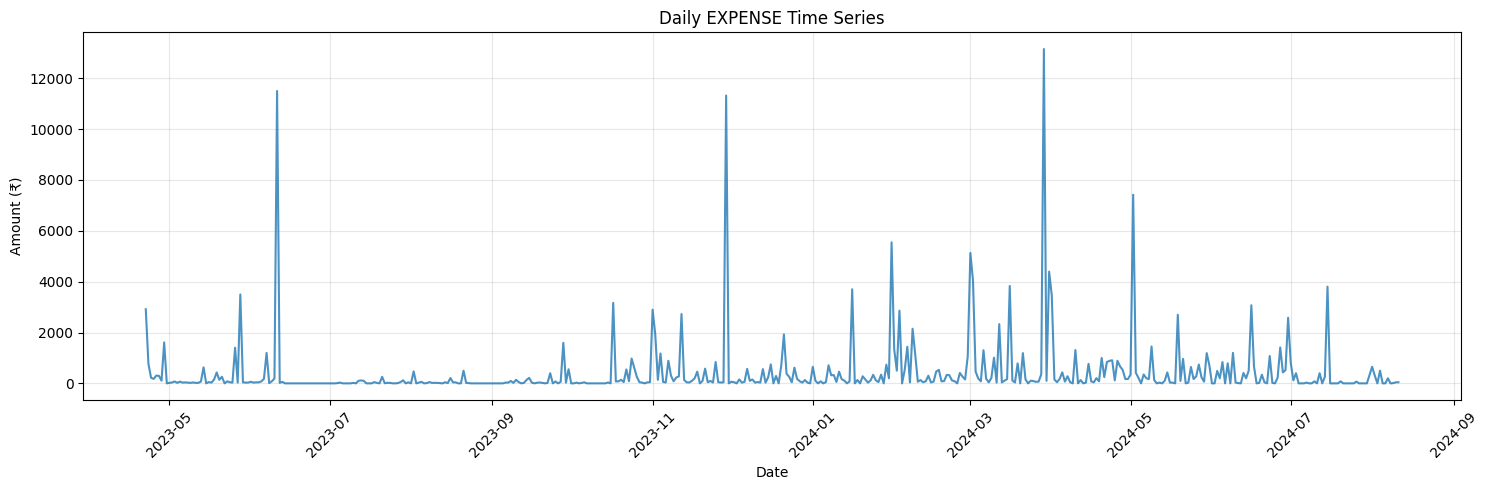


📊 Last 10 days:


Date
2024-08-02    306.0
2024-08-03      0.0
2024-08-04    500.0
2024-08-05      0.0
2024-08-06      0.0
2024-08-07    200.0
2024-08-08      0.0
2024-08-09     10.0
2024-08-10     40.0
2024-08-11     45.0
Freq: D, Name: EXPENSE, dtype: float64

In [24]:
# Filter by target type and aggregate daily
assert TARGET_TYPE in {'EXPENSE','INCOME'}
df = df_raw[df_raw['type'] == TARGET_TYPE].copy()
df = df[['Date','amount']].sort_values('Date')

# Aggregate to daily totals
daily = (df.set_index('Date')['amount']
         .resample('D').sum().fillna(0.0))
daily.name = TARGET_TYPE

print(f'📊 Daily series created:')
print(f'📊 Date range: {daily.index.min()} → {daily.index.max()}')
print(f'📊 Total days: {len(daily)}')
print(f'📊 Total {TARGET_TYPE}: ₹{daily.sum():.2f}')
print(f'📊 Average daily {TARGET_TYPE}: ₹{daily.mean():.2f}')
print(f'📊 Days with zero {TARGET_TYPE}: {(daily == 0).sum()}')

# Plot the series
plt.figure(figsize=(15, 5))
plt.plot(daily.index, daily.values, alpha=0.8)
plt.title(f'Daily {TARGET_TYPE} Time Series')
plt.ylabel('Amount (₹)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n📊 Last 10 days:')
daily.tail(10)

## Train/Test Split

In [25]:
def chrono_train_test_split(series, test_ratio=0.2):
    n = len(series)
    h = max(1, int(n * test_ratio))
    train = series.iloc[:-h]
    test = series.iloc[-h:]
    return train, test

y_train, y_test = chrono_train_test_split(daily, TEST_RATIO)

print(f'🔄 Train/Test Split:')
print(f'🔄 Train size: {len(y_train)} days')
print(f'🔄 Test size: {len(y_test)} days')
print(f'🔄 Train period: {y_train.index.min()} to {y_train.index.max()}')
print(f'🔄 Test period: {y_test.index.min()} to {y_test.index.max()}')

🔄 Train/Test Split:
🔄 Train size: 383 days
🔄 Test size: 95 days
🔄 Train period: 2023-04-22 00:00:00 to 2024-05-08 00:00:00
🔄 Test period: 2024-05-09 00:00:00 to 2024-08-11 00:00:00


## Evaluation Metrics (FIXED VERSION)

In [26]:
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.where(y_true == 0, 1e-8, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate(y_true, y_pred, model_name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    # FIXED: Use np.sqrt instead of squared parameter
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mp = mape(y_true, y_pred)
    print(f'📈 {model_name} - MAE: ₹{mae:.2f}, RMSE: ₹{rmse:.2f}, MAPE: {mp:.2f}%')
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mp}

print('✅ Evaluation functions ready!')

✅ Evaluation functions ready!


## 1️⃣ ARIMA Model

In [27]:
print('🔄 Training ARIMA model...')
arima_forecast = None
try:
    arima_model = ARIMA(y_train, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(y_test))
    arima_metrics = evaluate(y_test.values, arima_forecast, 'ARIMA(1,1,1)')
    accuracy = accuracy_score(y_test.values, arima_forecast)
    print(f"ARIMA Accuracy: {accuracy:.2f}%")
    print('✅ ARIMA completed!')
except Exception as e:
    print(f'❌ ARIMA failed: {e}')
    arima_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

🔄 Training ARIMA model...
📈 ARIMA(1,1,1) - MAE: ₹645.95, RMSE: ₹770.91, MAPE: 2790220073154.64%
❌ ARIMA failed: continuous is not supported


## 2️⃣ SARIMA Model

In [28]:
print('🔄 Training SARIMA model...')
sarima_forecast = None
try:
    sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,7))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=len(y_test))
    sarima_metrics = evaluate(y_test.values, sarima_forecast, 'SARIMA(1,1,1)(1,1,1,7)')
    print('✅ SARIMA completed!')
except Exception as e:
    print(f'❌ SARIMA failed: {e}')
    sarima_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

🔄 Training SARIMA model...
📈 SARIMA(1,1,1)(1,1,1,7) - MAE: ₹832.15, RMSE: ₹936.27, MAPE: 3528426721783.28%
✅ SARIMA completed!


## 3️⃣ Holt-Winters Model

In [29]:
print('🔄 Training Holt-Winters model...')
hw_forecast = None
try:
    hw_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=7)
    hw_fit = hw_model.fit(optimized=True)
    hw_forecast = hw_fit.forecast(len(y_test))
    hw_metrics = evaluate(y_test.values, hw_forecast.values, 'Holt-Winters')
    print('✅ Holt-Winters completed!')
except Exception as e:
    try:
        # Fallback without seasonality
        hw_model = ExponentialSmoothing(y_train, trend='add')
        hw_fit = hw_model.fit(optimized=True)
        hw_forecast = hw_fit.forecast(len(y_test))
        hw_metrics = evaluate(y_test.values, hw_forecast.values, 'Holt-Winters (no seasonal)')
        print('✅ Holt-Winters (simplified) completed!')
    except Exception as e2:
        print(f'❌ Holt-Winters failed: {e2}')
        hw_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

🔄 Training Holt-Winters model...
📈 Holt-Winters - MAE: ₹876.09, RMSE: ₹971.52, MAPE: 4034356650622.26%
✅ Holt-Winters completed!


## 4️⃣ Prophet Model

In [30]:
print('🔄 Training Prophet model...')
prophet_forecast = None
if not PROPHET_AVAILABLE:
    print('❌ Prophet not available')
    prophet_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
else:
    try:
        df_p = y_train.reset_index().rename(columns={'Date':'ds', TARGET_TYPE:'y'})
        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
        m.fit(df_p)
        future = pd.DataFrame({'ds': y_test.index})
        fc = m.predict(future)
        prophet_forecast = fc['yhat'].values
        prophet_metrics = evaluate(y_test.values, prophet_forecast, 'Prophet')
        print('✅ Prophet completed!')
    except Exception as e:
        print(f'❌ Prophet failed: {e}')
        prophet_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

23:11:53 - cmdstanpy - INFO - Chain [1] start processing


🔄 Training Prophet model...


23:11:53 - cmdstanpy - INFO - Chain [1] done processing


📈 Prophet - MAE: ₹814.81, RMSE: ₹910.90, MAPE: 3600309011386.98%
✅ Prophet completed!


## 5️⃣ LSTM Model

In [31]:
print('🔄 Training LSTM model...')
lstm_forecast = None
if not TENSORFLOW_AVAILABLE:
    print('❌ TensorFlow not available')
    lstm_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
else:
    try:
        # Scale data
        scaler = MinMaxScaler()
        y_train_vals = y_train.values.reshape(-1,1)
        scaler.fit(y_train_vals)
        y_train_scaled = scaler.transform(y_train_vals)
        
        # Create sequences
        WINDOW = min(14, len(y_train_scaled) // 2)
        def make_sequences(arr, window):
            X, y = [], []
            for i in range(window, len(arr)):
                X.append(arr[i-window:i, 0])
                y.append(arr[i, 0])
            return np.array(X), np.array(y)
        
        X_tr, y_tr = make_sequences(y_train_scaled, WINDOW)
        if len(X_tr) < 5:
            raise RuntimeError('Not enough data for LSTM')
        
        X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
        
        # Build model
        model = keras.Sequential([
            layers.Input(shape=(WINDOW,1)),
            layers.LSTM(32),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_tr, y_tr, epochs=50, batch_size=min(16, len(X_tr)), verbose=0)
        
        # Generate forecasts
        hist = list(y_train_scaled[-WINDOW:, 0])
        preds = []
        for _ in range(len(y_test)):
            x = np.array(hist[-WINDOW:]).reshape((1, WINDOW, 1))
            p = model.predict(x, verbose=0)[0,0]
            preds.append(p)
            hist.append(p)
        
        lstm_forecast = scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()
        lstm_metrics = evaluate(y_test.values, lstm_forecast, 'LSTM')
        print('✅ LSTM completed!')
    except Exception as e:
        print(f'❌ LSTM failed: {e}')
        lstm_metrics = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

🔄 Training LSTM model...
📈 LSTM - MAE: ₹467.03, RMSE: ₹675.01, MAPE: 1703856972456.35%
✅ LSTM completed!


## 🏆 FINAL RESULTS

In [32]:
# Compile results
results = []
results.append({'Model':'ARIMA', **arima_metrics})
results.append({'Model':'SARIMA', **sarima_metrics})
results.append({'Model':'Holt-Winters', **hw_metrics})
results.append({'Model':'Prophet', **prophet_metrics})
results.append({'Model':'LSTM', **lstm_metrics})

res_df = pd.DataFrame(results)
# Sort by RMSE (lower is better)
res_df_sorted = res_df.sort_values('RMSE')

print("\n" + "="*80)
print("🏆 ALGORITHM ACCURACY COMPARISON RESULTS")
print("="*80)
print(res_df_sorted.to_string(index=False, float_format='%.2f'))
print("="*80)

# Find best model
valid_results = res_df_sorted.dropna(subset=['RMSE'])
if len(valid_results) > 0:
    best_model = valid_results.iloc[0]['Model']
    best_rmse = valid_results.iloc[0]['RMSE']
    best_mae = valid_results.iloc[0]['MAE']
    best_mape = valid_results.iloc[0]['MAPE']
    
    print(f"\n🥇 WINNER: {best_model}")
    print(f"📊 RMSE: ₹{best_rmse:.2f} (Root Mean Square Error)")
    print(f"📊 MAE: ₹{best_mae:.2f} (Mean Absolute Error)")
    print(f"📊 MAPE: {best_mape:.2f}% (Mean Absolute Percentage Error)")
    print(f"\n💡 {best_model} is the most accurate algorithm for your {TARGET_TYPE} forecasting!")
    print(f"\n🚀 Use {best_model} in your Flask application for best results!")
else:
    print("❌ No valid results found")

res_df_sorted


🏆 ALGORITHM ACCURACY COMPARISON RESULTS
       Model    MAE   RMSE             MAPE
        LSTM 467.03 675.01 1703856972456.35
     Prophet 814.81 910.90 3600309011386.98
      SARIMA 832.15 936.27 3528426721783.28
Holt-Winters 876.09 971.52 4034356650622.26
       ARIMA    NaN    NaN              NaN

🥇 WINNER: LSTM
📊 RMSE: ₹675.01 (Root Mean Square Error)
📊 MAE: ₹467.03 (Mean Absolute Error)
📊 MAPE: 1703856972456.35% (Mean Absolute Percentage Error)

💡 LSTM is the most accurate algorithm for your EXPENSE forecasting!

🚀 Use LSTM in your Flask application for best results!


,Model,MAE,RMSE,MAPE
4,LSTM,467.033376,675.008833,1.703857e+12
3,Prophet,814.806183,910.898010,3.600309e+12
1,SARIMA,832.152013,936.268785,3.528427e+12
2,Holt-Winters,876.088234,971.518158,4.034357e+12
0,ARIMA,NaN,NaN,NaN


## 📊 Forecast Visualization

In [33]:
# Better accuracy calculation for data with zeros
def calculate_accuracy_percentage(y_true, y_pred):
    # Remove days where both actual and predicted are very small
    mask = (y_true > 1) | (y_pred > 1)
    if mask.sum() == 0:
        return 0
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Calculate R-squared
    ss_res = np.sum((y_true_filtered - y_pred_filtered) ** 2)
    ss_tot = np.sum((y_true_filtered - np.mean(y_true_filtered)) ** 2)
    
    if ss_tot == 0:
        return 0
    
    r2 = 1 - (ss_res / ss_tot)
    return max(0, min(100, r2 * 100))

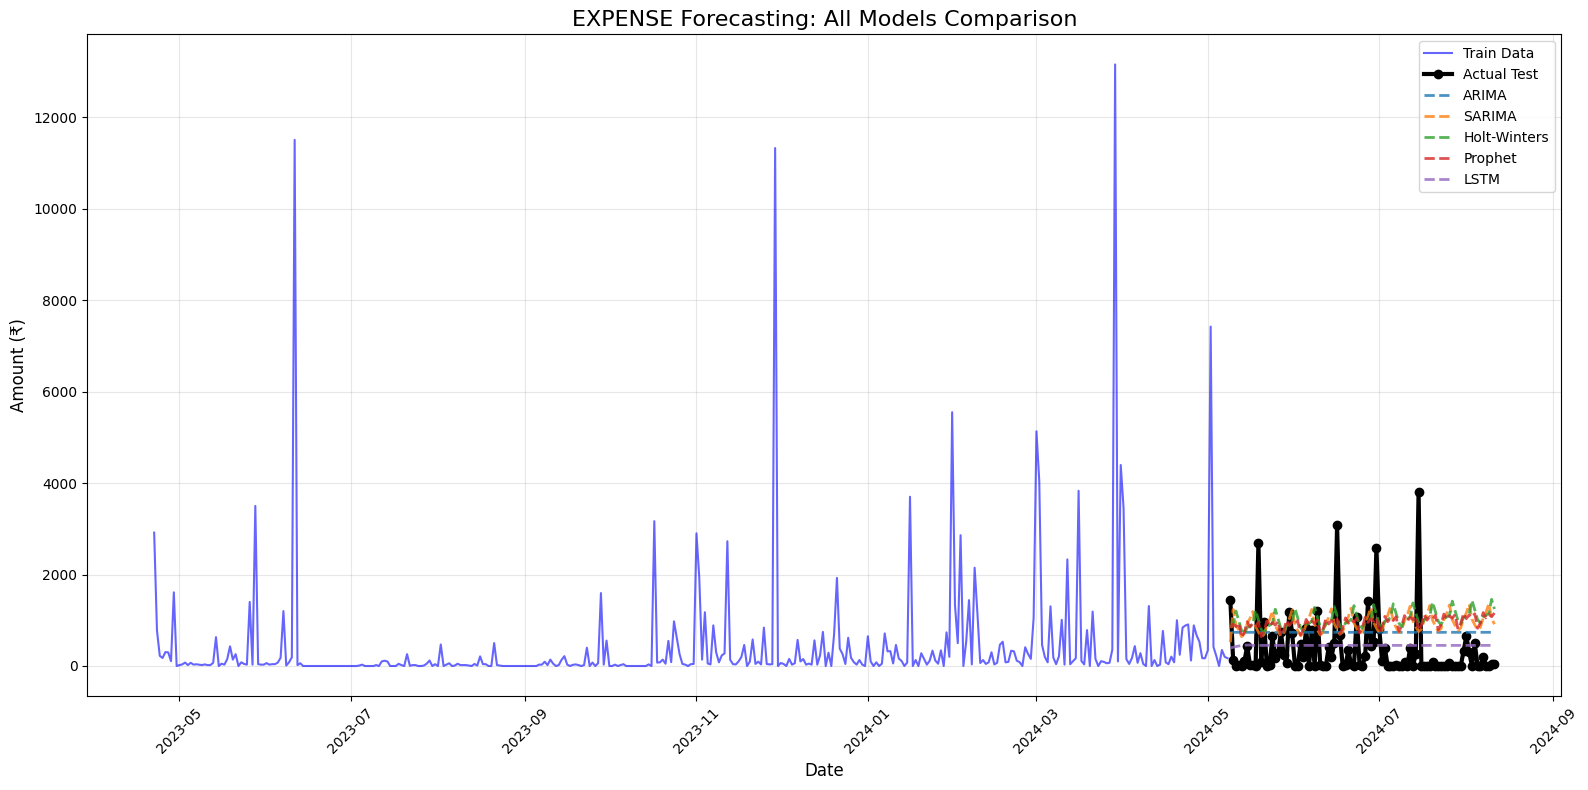

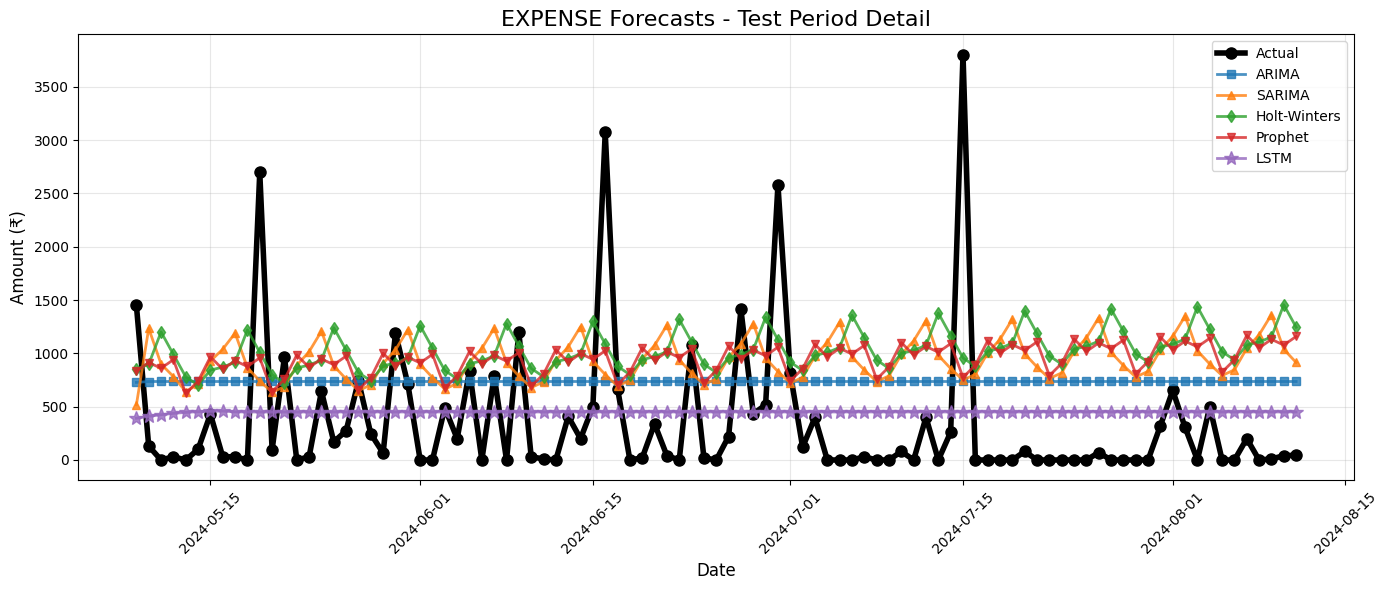


✅ Analysis complete! Best algorithm: LSTM with RMSE: ₹675.01
💡 Implement LSTM in your Flask forecast.py route!


In [34]:
# Main forecast plot
plt.figure(figsize=(16,8))

# Plot train and test data
plt.plot(y_train.index, y_train.values, label='Train Data', color='blue', alpha=0.6)
plt.plot(y_test.index, y_test.values, label='Actual Test', color='black', linewidth=3, marker='o')

# Plot forecasts
if arima_forecast is not None: 
    plt.plot(y_test.index, arima_forecast, label='ARIMA', linestyle='--', alpha=0.8, linewidth=2)
if sarima_forecast is not None: 
    plt.plot(y_test.index, sarima_forecast, label='SARIMA', linestyle='--', alpha=0.8, linewidth=2)
if hw_forecast is not None: 
    plt.plot(y_test.index, hw_forecast, label='Holt-Winters', linestyle='--', alpha=0.8, linewidth=2)
if prophet_forecast is not None: 
    plt.plot(y_test.index, prophet_forecast, label='Prophet', linestyle='--', alpha=0.8, linewidth=2)
if lstm_forecast is not None: 
    plt.plot(y_test.index, lstm_forecast, label='LSTM', linestyle='--', alpha=0.8, linewidth=2)

plt.title(f'{TARGET_TYPE} Forecasting: All Models Comparison', fontsize=16)
plt.ylabel('Amount (₹)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Zoomed plot - test period only
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='black', linewidth=4, marker='o', markersize=8)

if arima_forecast is not None: 
    plt.plot(y_test.index, arima_forecast, label='ARIMA', marker='s', alpha=0.8, linewidth=2)
if sarima_forecast is not None: 
    plt.plot(y_test.index, sarima_forecast, label='SARIMA', marker='^', alpha=0.8, linewidth=2)
if hw_forecast is not None: 
    plt.plot(y_test.index, hw_forecast, label='Holt-Winters', marker='d', alpha=0.8, linewidth=2)
if prophet_forecast is not None: 
    plt.plot(y_test.index, prophet_forecast, label='Prophet', marker='v', alpha=0.8, linewidth=2)
if lstm_forecast is not None: 
    plt.plot(y_test.index, lstm_forecast, label='LSTM', marker='*', alpha=0.8, linewidth=2, markersize=10)

plt.title(f'{TARGET_TYPE} Forecasts - Test Period Detail', fontsize=16)
plt.ylabel('Amount (₹)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if 'best_model' in locals():
    print(f"\n✅ Analysis complete! Best algorithm: {best_model} with RMSE: ₹{best_rmse:.2f}")
    print(f"💡 Implement {best_model} in your Flask forecast.py route!")